In [1]:
import os
import joblib
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from prediction_utils.pytorch_utils.metrics import StandardEvaluator, CalibrationEvaluator
from matplotlib.ticker import MaxNLocator
from matplotlib.pyplot import savefig
from matplotlib.ticker import FormatStrFormatter
from sklearn.calibration import calibration_curve

pd.options.display.max_rows = 100

In [2]:
artifacts_fpath = '/local-scratch/nigam/projects/lguo/temp_ds_shift_robustness/dg/experiments/baseline/artifacts'
tasks = ['hospital_mortality','LOS_7','readmission_30','icu_admission']

g1 = '2017'
g2 = '2021'

#### Distribution of Predicted probability Conditioned on Y (09-12)

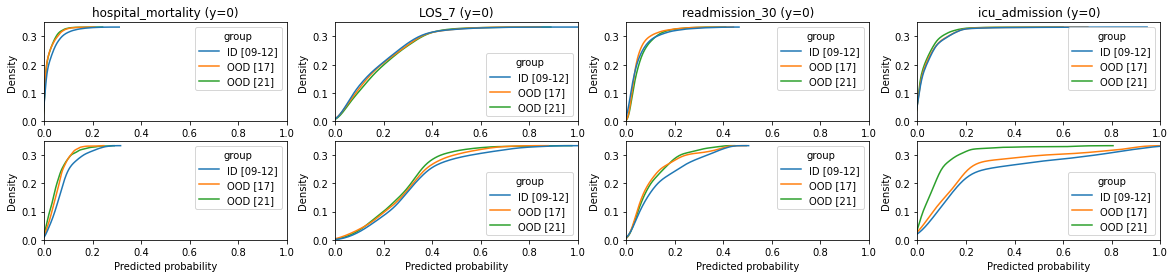

<Figure size 432x288 with 0 Axes>

In [3]:
id_group = '2009_2010_2011_2012'

fig, axes = plt.subplots(
    ncols = len(tasks),
    nrows = 2,
    figsize=(20,4)
)
for r in range(2):
    for c,task in enumerate(tasks):
        fpath = os.path.join(
            artifacts_fpath,
            task,
            "pred_probs",
            "nn_2009_2010_2011_2012"
        )
        fname = [x for x in os.listdir(fpath) if 'best_model' in x]
        df_probs = pd.read_csv(f"{fpath}/{fname[0]}", dtype={'test_group':'str'}).round(3)
        id_probs = df_probs.query("test_group==[@id_group] and labels==@r")[['labels','pred_probs']].assign(group='ID [09-12]').sample(10000,replace=True)
        ood_mid_probs = df_probs.query("test_group==[@g1] and labels==@r")[['labels','pred_probs']].assign(group=f'OOD [{g1[-2:]}]').sample(10000,replace=True)
        ood_worst_probs = df_probs.query("test_group==[@g2] and labels==@r")[['labels','pred_probs']].assign(group=f'OOD [{g2[-2:]}]').sample(10000,replace=True)
        data = pd.concat((id_probs,ood_mid_probs,ood_worst_probs),ignore_index=True)
        sns.kdeplot(
            data = data,
            x = 'pred_probs',
            hue='group',
            ax = axes[r][c],
            cumulative=True
        )
        axes[r][c].set_xlim([0,1])

        if c==0:
            axes[r][c].set_ylabel("Density")
        if r==1:
            axes[r][c].set_xlabel("Predicted probability")
        else:
            axes[r][c].set_title(f"{task} (y={r})")
plt.show()
plt.tight_layout()

#### Calibration Curves Using Predicted Probability (09-12)

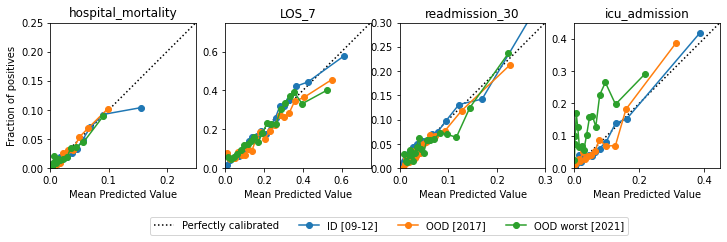

<Figure size 432x288 with 0 Axes>

In [4]:
lims = {
    'hospital_mortality':[0, 0.25],
    'LOS_7':[0, 0.75],
    'readmission_30':[0, 0.3],
    'icu_admission':[0, 0.45]
}

nbins = 20

fig, axes = plt.subplots(ncols = len(tasks),figsize=(12,5))
for c,task in enumerate(tasks):
    fpath = os.path.join(
        artifacts_fpath,
        task,
        "pred_probs",
        "nn_2009_2010_2011_2012"
    )
    fname = [x for x in os.listdir(fpath) if 'best_model' in x]
    df_probs = pd.read_csv(f"{fpath}/{fname[0]}", dtype={'test_group':'str'}).round(3)
    id_probs = df_probs.query("test_group==['2009_2010_2011_2012']")[['labels','pred_probs']]
    ood_mid_probs = df_probs.query("test_group==[@g1]")[['labels','pred_probs']]
    ood_worst_probs = df_probs.query("test_group==[@g2]")[['labels','pred_probs']]
    
    # perfect calibration
    axes[c].plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    
    # ID
    fraction_of_positives, mean_predicted_value = calibration_curve(
        id_probs['labels'],
        id_probs['pred_probs'],
        n_bins=nbins,
        strategy='quantile'
    )
    
    axes[c].plot(
        mean_predicted_value, 
        fraction_of_positives, 
        "o-", 
        label="ID [09-12]"
    )
    
    # OOD mid
    fraction_of_positives, mean_predicted_value = calibration_curve(
        ood_mid_probs['labels'],
        ood_mid_probs['pred_probs'],
        n_bins=nbins,
        strategy='quantile'
    )
    
    axes[c].plot(
        mean_predicted_value, 
        fraction_of_positives, 
        "o-", 
        label=f"OOD [{g1}]"
    )
    
    # OOD worst
    fraction_of_positives, mean_predicted_value = calibration_curve(
        ood_worst_probs['labels'],
        ood_worst_probs['pred_probs'],
        n_bins=nbins,
        strategy='quantile'
    )
    
    axes[c].plot(
        mean_predicted_value, 
        fraction_of_positives, 
        "o-", 
        label=f"OOD worst [{g2}]"
    )
    
    if c==0:
        axes[c].set_ylabel("Fraction of positives")
    
    axes[c].set_xlabel("Mean Predicted Value")
    axes[c].set_ylim(lims[task])
    axes[c].set_xlim(lims[task])
    #axes[c].legend(loc="upper left")
    axes[c].set_title(task)
    axes[c].set_aspect('equal')
    if c == len(tasks)-1:
        axes[c].legend(
            bbox_to_anchor=(0.4,-0.3),
            ncol=4,
            frameon=True
        )
plt.show()
plt.tight_layout()

#### Training & validation loss

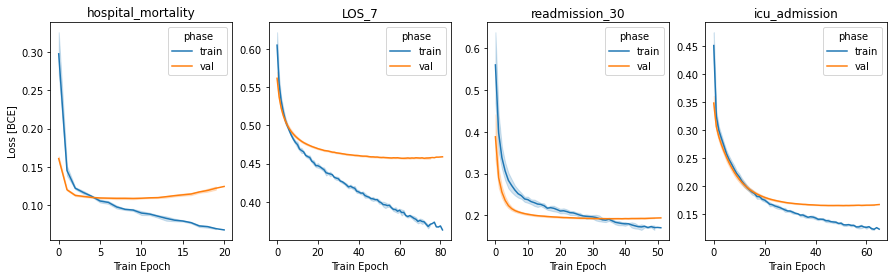

In [5]:
fig,axes = plt.subplots(1,len(tasks),figsize=(15,4))

for c,task in enumerate(tasks):
    
    df = pd.DataFrame()
    
    # get selected model
    fpath = os.path.join(
        artifacts_fpath,
        task,
        'models/nn_2009_2010_2011_2012',
    )
    
    folder_name = [
        x for x in os.listdir(fpath)
        if 'best_model' in x
    ]
    
    file_names = [
        x for x in os.listdir(f"{fpath}/{folder_name[0]}")
        if "train_scores.csv" in x
    ]
    
    # read train and val scores for model
    df = pd.concat((
        pd.read_csv(
            f"{fpath}/{folder_name[0]}/{x}"
        )
        for x in file_names
    ))
    
    df = df.query("metric=='loss_bce'").reset_index(drop=True)
    
    sns.lineplot(
        data=df,
        x='epoch',
        y='performance',
        hue='phase',
        ax = axes[c]
    )
    axes[c].set_title(task)
    axes[c].set_xlabel('Train Epoch')
    if c==0:
        axes[c].set_ylabel('Loss [BCE]')
    else:
        axes[c].set_ylabel('')

plt.show()